In [1]:
from data import iid
from network import teacher, student, base, ensemble
from solver import teacher_student_solver
import sklearn.metrics, sklearn.decomposition
import numpy as np
import torch.nn as nn
import torch


import matplotlib.pyplot as plt

In [2]:
D = 100
iid_task = iid.IIDTask(batch_size = 256 , continuous_input_dim = D , binary_input_dim = 0)

In [3]:
task1_teacher_binary = teacher.BinaryTeacher(input_dimension = D, hidden_dimensions=[1])
task1_teacher_conti = teacher.ContinuousTeacher(input_dimension = D, hidden_dimensions=[1])

task2_teacher_binary = teacher.BinaryTeacher(input_dimension = D, hidden_dimensions=[1])
task2_teacher_conti = teacher.ContinuousTeacher(input_dimension = D, hidden_dimensions=[1])

teacher_ensemble= ensemble.SharedEnsemble(networks=[[task1_teacher_conti, task2_teacher_conti], 
                                        [task1_teacher_binary, task2_teacher_binary]], shared_dimensions = [99,99])

In [4]:
task1_student_binary = student.BinaryStudent(input_dimension = D, hidden_dimensions=[1])
task1_student_conti = student.ContinuousStudent(input_dimension = D, hidden_dimensions=[1])

task2_student_binary = student.BinaryStudent(input_dimension = D, hidden_dimensions=[1])
task2_student_conti = student.ContinuousStudent(input_dimension = D, hidden_dimensions=[1])

student_ensemble= ensemble.SharedEnsemble(networks=[[task1_student_conti, task2_student_conti], 
                                        [task1_student_binary, task2_student_binary]], shared_dimensions = [99,99])

In [5]:
## learning rate and L2 regularizer weight is randomly set, but seems to be pretty robust
solver=teacher_student_solver.TeacherStudentElementwiseRegressionSolver(criterion = nn.MSELoss(reduction='none'), lr = 0.1, weight_decay = 1e-3,
                                                              optimizer_type = "sgd", logdir = "", teacher_network = teacher_ensemble, 
                                                                     student_network = student_ensemble)

In [6]:
## Reject samples for training where yb1 = yb2
def rejection_intersect_task(x, teacher_outputs):
    #accept_index = torch.where((teacher_outputs[0] != teacher_outputs[2]))[0]
    accept_index = torch.where((teacher_outputs[2].squeeze()==0) | (teacher_outputs[3].squeeze()==0) )[0]
    new_x = x[accept_index, :]
    if len(new_x) == 0:
        return None
    else:
        return new_x
    
solver.train(data_loader = iid_task, num_iter = 1000, rejection_func = rejection_intersect_task)

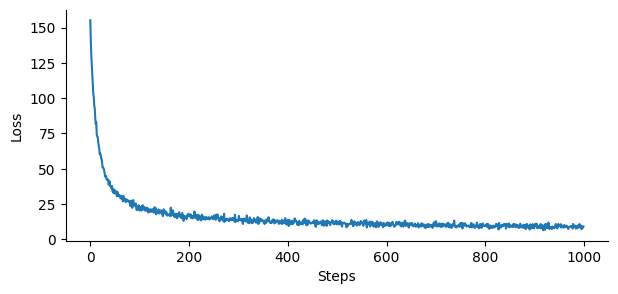

In [7]:
plt.figure(figsize=(7,3))
ax1 = plt.subplot(111)
ax1.plot(solver.history['loss'])
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

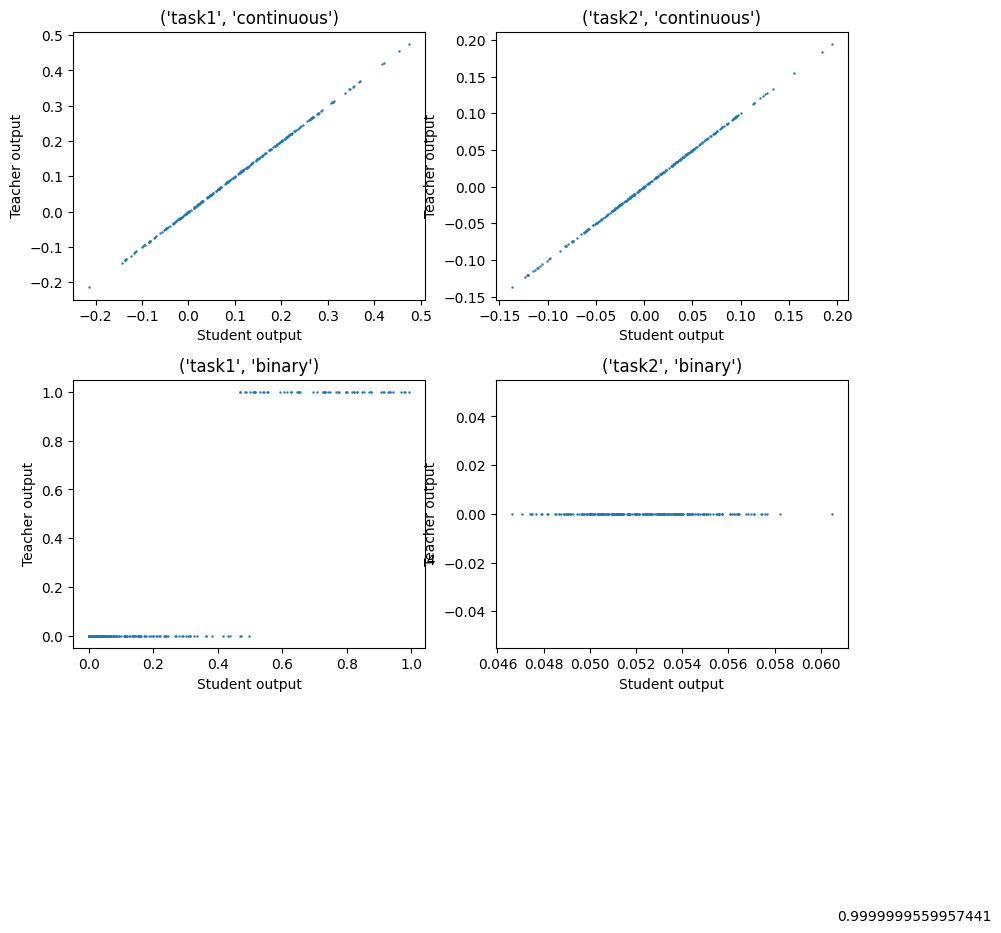

In [9]:

iter_idx = 500

plt.figure(figsize=(10,8))
value_type = {0: ('task1', 'continuous'), 1: ('task2', 'continuous'), 2: ('task1', 'binary'), 3: ('task2', 'binary')}
plt.subplots_adjust(hspace=0.3)
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    ax.scatter(solver.history['prediction'][iter_idx][:,i], solver.history['true'][iter_idx][:,i], s=0.5)
    if value_type[i][1]=='continuous':
        r2=sklearn.metrics.r2_score(solver.history['true'][iter_idx][:,i], solver.history['prediction'][iter_idx][:,i])
        ax.text(0.2,-1, r2)
    ax.set_xlabel('Student output')
    ax.set_ylabel('Teacher output')
    ax.set_title(f'{value_type[i]}')

In [10]:
## Reject samples for training where yb1 != yb2
def rejection_individual_task(x, teacher_outputs):
    accept_index = torch.where((teacher_outputs[2].squeeze()==1) & (teacher_outputs[3].squeeze()==1) )[0]
    new_x = x[accept_index, :]
    if len(new_x) == 0:
        return None
    else:
        return new_x

x = iid_task.get_batch()['x']
teacher_test_output, student_test_output=solver.inference(x, rejection_func = None)

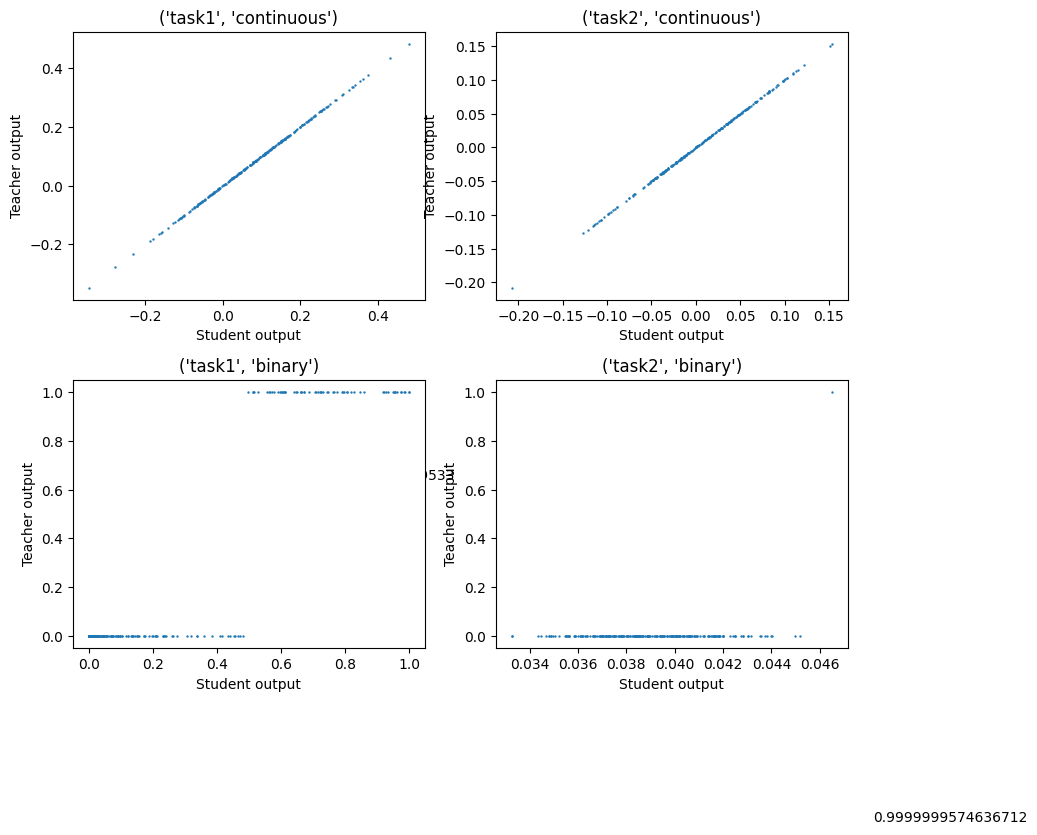

In [11]:
plt.figure(figsize=(10,8))
plt.subplots_adjust(hspace=0.3)
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    ax.scatter(student_test_output[i], teacher_test_output[i], s=0.5)
    if value_type[i][1]=='continuous':
        r2=sklearn.metrics.r2_score(teacher_test_output[i], student_test_output[i])
        ax.text(0.2,-1, r2)
    ax.set_xlabel('Student output')
    ax.set_ylabel('Teacher output')
    ax.set_title(f'{value_type[i]}')

In [12]:
task1_teacher_binary = teacher.BinaryTeacher(input_dimension = D, hidden_dimensions=[1])
task1_teacher_conti = teacher.ContinuousTeacher(input_dimension = D, hidden_dimensions=[1])

task2_teacher_binary = teacher.BinaryTeacher(input_dimension = D, hidden_dimensions=[1])
task2_teacher_conti = teacher.ContinuousTeacher(input_dimension = D, hidden_dimensions=[1])

teacher_ensemble= ensemble.SharedEnsemble(networks=[[task1_teacher_conti, task2_teacher_conti], 
                                        [task1_teacher_binary, task2_teacher_binary]], shared_dimensions = [99,99])

In [13]:
task1_student_binary = student.BinaryStudent(input_dimension = D, hidden_dimensions=[1])
task1_student_conti = student.ContinuousStudent(input_dimension = D, hidden_dimensions=[1])

task2_student_binary = student.BinaryStudent(input_dimension = D, hidden_dimensions=[1])
task2_student_conti = student.ContinuousStudent(input_dimension = D, hidden_dimensions=[1])

student_ensemble= ensemble.SharedEnsemble(networks=[[task1_student_conti, task2_student_conti], 
                                        [task1_student_binary, task2_student_binary]], shared_dimensions = [99,99])

In [14]:
## learning rate and L2 regularizer weight is randomly set, but seems to be pretty robust
solver=teacher_student_solver.TeacherStudentElementwiseRegressionSolver(criterion = nn.MSELoss(reduction='none'), lr = 0.1, weight_decay = 1e-3,
                                                              optimizer_type = "sgd", logdir = "", teacher_network = teacher_ensemble, 
                                                                     student_network = student_ensemble)

In [15]:
## Reject samples for training where yb1 = yb2
    
solver.train(data_loader = iid_task, num_iter = 1000, rejection_func = rejection_individual_task)

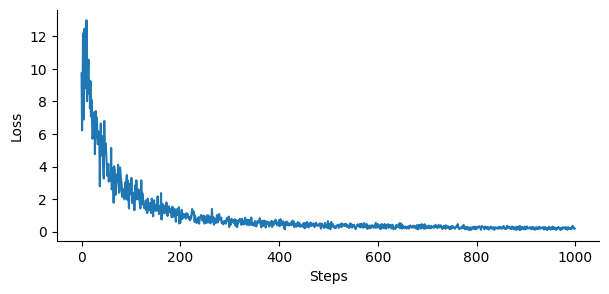

In [16]:
plt.figure(figsize=(7,3))
ax1 = plt.subplot(111)
ax1.plot(solver.history['loss'])
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

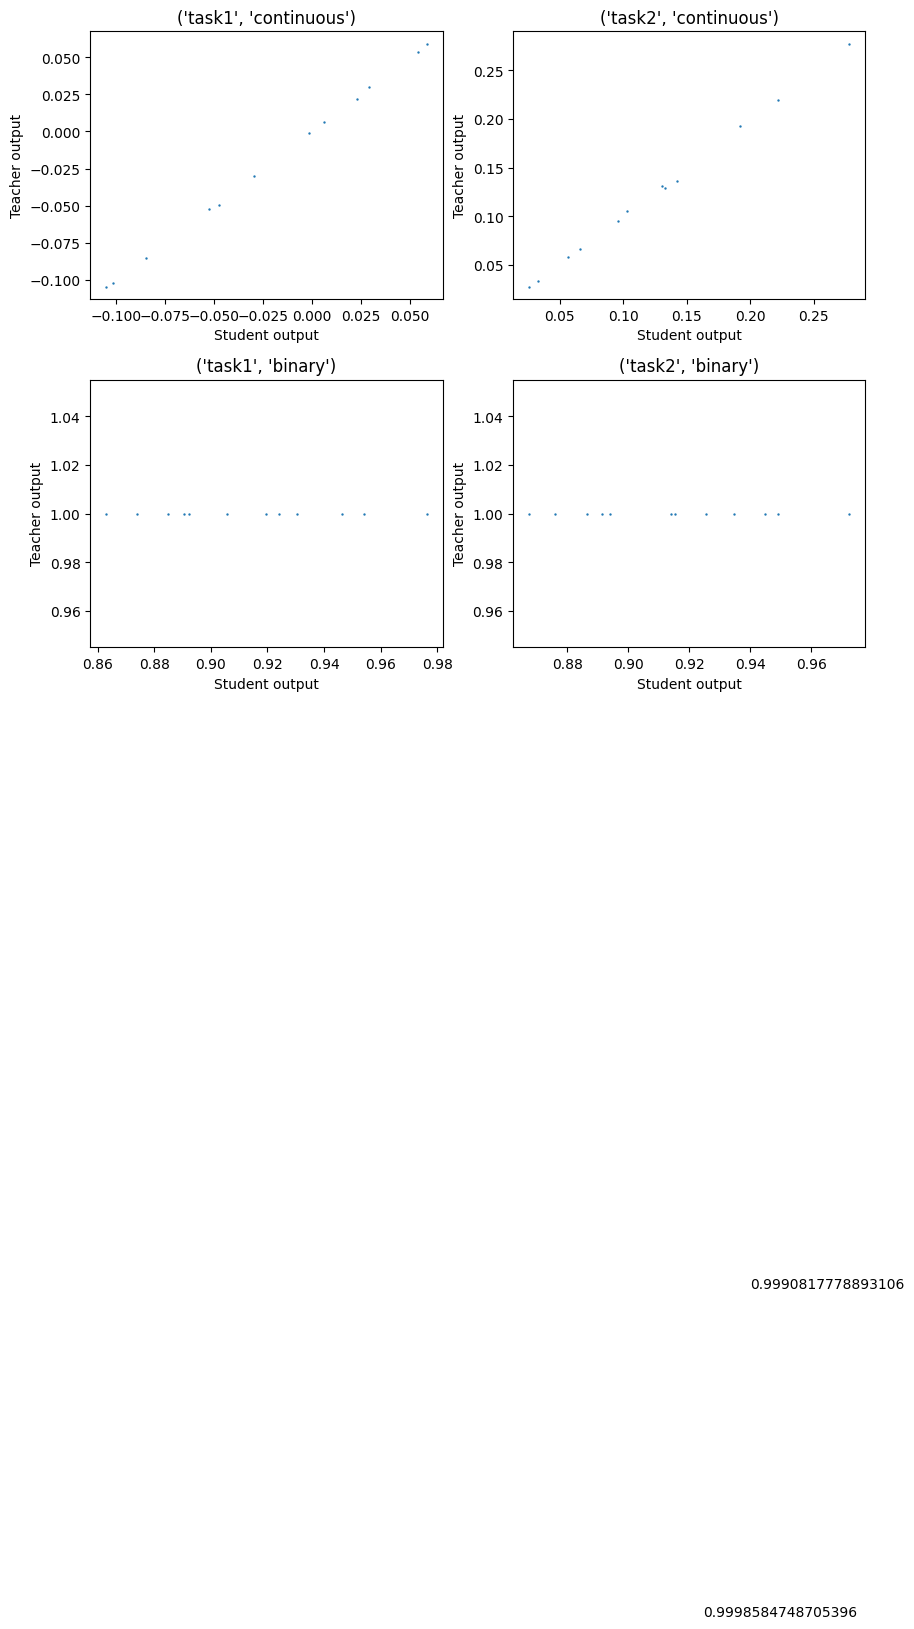

In [19]:

iter_idx = 500
plt.figure(figsize=(10,8))
value_type = {0: ('task1', 'continuous'), 1: ('task2', 'continuous'), 2: ('task1', 'binary'), 3: ('task2', 'binary')}
plt.subplots_adjust(hspace=0.3)
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    ax.scatter(solver.history['prediction'][iter_idx][:,i], solver.history['true'][iter_idx][:,i], s=0.5)
    if value_type[i][1]=='continuous':
        r2=sklearn.metrics.r2_score(solver.history['true'][iter_idx][:,i], solver.history['prediction'][iter_idx][:,i])
        ax.text(0.2,-1, r2)
    ax.set_xlabel('Student output')
    ax.set_ylabel('Teacher output')
    ax.set_title(f'{value_type[i]}')

In [17]:
x = iid_task.get_batch()['x']
teacher_test_output, student_test_output=solver.inference(x, rejection_func = None)

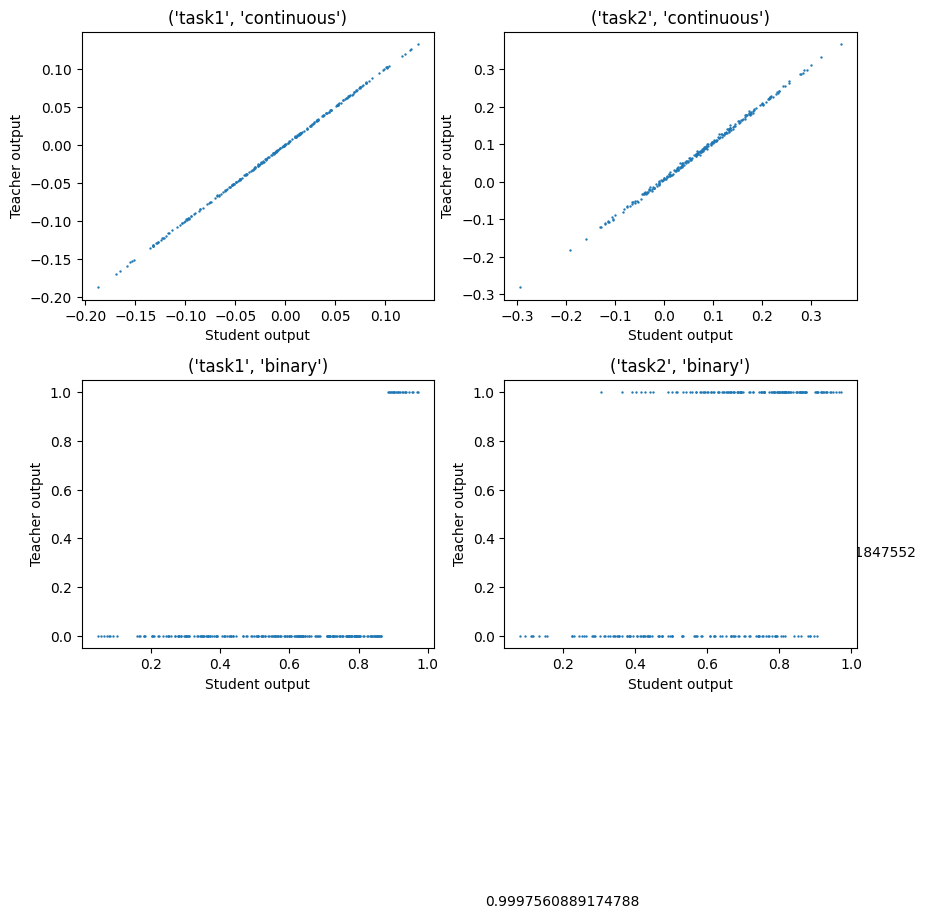

In [18]:
iter = 500
plt.figure(figsize=(10,8))
plt.subplots_adjust(hspace=0.3)
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    ax.scatter(student_test_output[i], teacher_test_output[i], s=0.5)
    if value_type[i][1]=='continuous':
        r2=sklearn.metrics.r2_score(teacher_test_output[i], student_test_output[i])
        ax.text(0.2,-1, r2)
    ax.set_xlabel('Student output')
    ax.set_ylabel('Teacher output')
    ax.set_title(f'{value_type[i]}')